In [1]:
import itertools
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier

# imputation
from miceforest import ImputationKernel

from gridsearch_custom import KFoldCrossValidator

# dimensionality reduction
import pacmap

# GOSDT
from gosdt_custom import CustomGOSDT, GridSearchCVGOSDT

# PyGAM
from pygam import LogisticGAM, s, f

# L0 Regularization GLM
import l0learn

# EBM
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# variable importance
import eli5
from eli5.sklearn import PermutationImportance

# Data Preprocessing
***

### Basic Preprocessing

In [2]:
df_raw = pd.read_csv('../data/telecom_customer_churn.csv')
df_population = pd.read_csv('../data/telecom_zipcode_population.csv')

df = df_raw.copy()
df = df.query('`Customer Status` != "Joined"').reset_index(drop=True)

# join population by zip-code
df = pd.merge(left=df, right=df_population, on='Zip Code')

# remove unwanted columns
dropped_columns = ['Customer ID', 'Churn Category', 'Churn Reason', 'Latitude', 'Longitude', 'Zip Code']
df = df[[col for col in df.columns if col not in dropped_columns]]

# impute categoricals as NA
impute_na = ['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
             'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Multiple Lines']

df[impute_na] = df[impute_na].fillna('NA')
df['Offer'] = df['Offer'].fillna('No Offer')

# fix data types
categorical_columns = ['Gender', 'Married', 'City', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 
                       'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
                       'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 
                       'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method',
                       'Customer Status']
df[categorical_columns] = df[categorical_columns].astype('category')

arranged_columns = list(df.columns[:-2])
arranged_columns.extend(['Population', 'Customer Status'])
df = df[arranged_columns]

## Train Test Split

In [3]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], 
                                                                test_size=0.3, 
                                                                random_state=4,
                                                                stratify=df.iloc[:, -1])

/home/vscode/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/vscode/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## MICE Imputation for numeric missing values

Before doing the imputation, collapse the City category.

In [4]:
rare_cities = df_X_train['City'].value_counts().index[df_X_train['City'].value_counts() <= 5]

df_X_train['City'] = df_X_train['City'].astype('object')
df_X_train.loc[df_X_train['City'].isin(rare_cities), 'City'] = 'Rare City'
df_X_train['City'] = df_X_train['City'].astype('category')

In [5]:
mice_kernel = ImputationKernel(
    data = df_X_train,
    save_all_iterations = True,
    random_state = 42
)

mice_kernel.mice(2)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

df_X_train_imp = mice_imputation.copy()

X_train_numeric = df_X_train_imp.select_dtypes(exclude=['category'])
y_train_numeric = df_y_train.map({'Stayed': 0, 'Churned': 1}).astype('float')

df_X_train_imp_dummies = pd.get_dummies(df_X_train_imp)

/home/vscode/.venv/lib/python3.10/site-packages/miceforest/ImputationKernel.py:370: UserWarning: [City] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


In [6]:
df_X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4612 entries, 6586 to 3725
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Gender                             4612 non-null   category
 1   Age                                4612 non-null   int64   
 2   Married                            4612 non-null   category
 3   Number of Dependents               4612 non-null   int64   
 4   City                               4612 non-null   category
 5   Number of Referrals                4612 non-null   int64   
 6   Tenure in Months                   4612 non-null   int64   
 7   Offer                              4612 non-null   category
 8   Phone Service                      4612 non-null   category
 9   Avg Monthly Long Distance Charges  4612 non-null   float64 
 10  Multiple Lines                     4612 non-null   category
 11  Internet Service                   4612 non-n

In [7]:
df_X_train_imp.head()

,Gender,Age,Married,Number of Dependents,City,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,...,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Population
6586,Male,22,No,0,Rare City,0,10,No Offer,Yes,17.98,...,Month-to-Month,No,Bank Withdrawal,75.05,786.3,0.0,0,179.80,966.10,301
1898,Female,42,No,0,Rare City,0,46,Offer B,Yes,32.78,...,Two Year,Yes,Bank Withdrawal,21.10,937.1,0.0,0,1507.88,2444.98,615
5073,Male,25,Yes,3,Rare City,1,72,No Offer,Yes,20.79,...,Two Year,Yes,Credit Card,97.75,6991.6,0.0,0,1496.88,8488.48,25566
1252,Male,44,No,0,Rare City,0,71,Offer A,Yes,41.34,...,One Year,Yes,Credit Card,79.05,5552.5,0.0,0,2935.14,8487.64,4882
5298,Male,19,Yes,0,Rare City,1,2,Offer E,Yes,20.50,...,Month-to-Month,No,Bank Withdrawal,76.40,151.8,0.0,0,41.00,192.80,406


# EDA
***

### PaCMAP Dimensionality Reduction

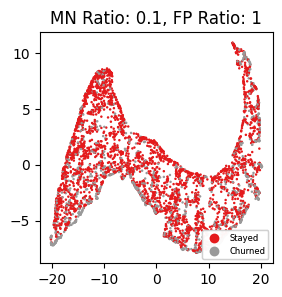

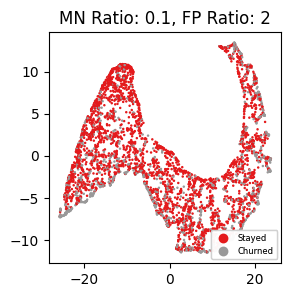

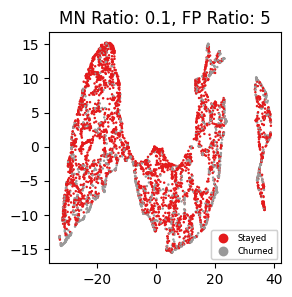

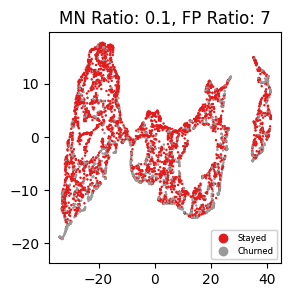

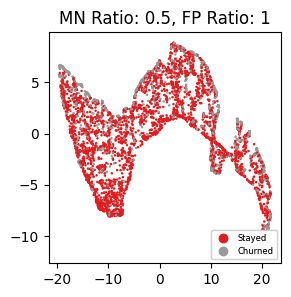

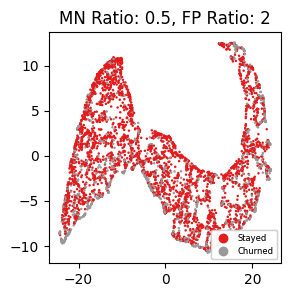

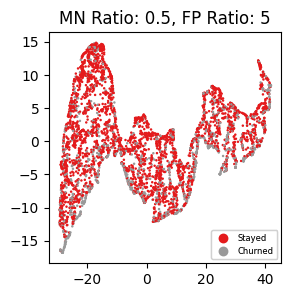

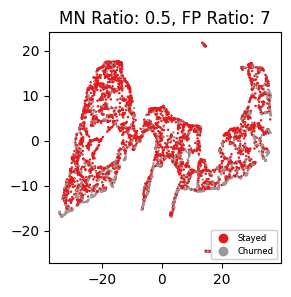

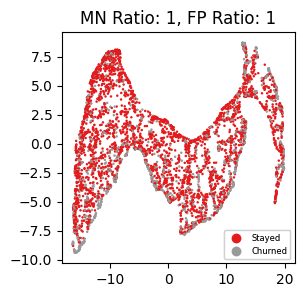

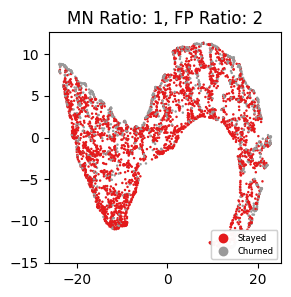

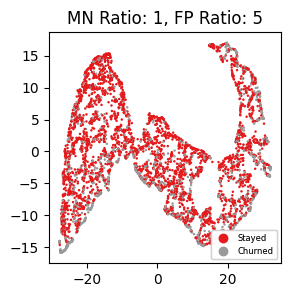

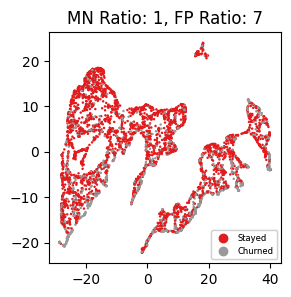

In [8]:
mn_ratio_list = [0.1, 0.5, 1]
fp_ratio_list = [1, 2, 5, 7]

pacmap_params_list = [mn_ratio_list, fp_ratio_list]

for element in itertools.product(*pacmap_params_list):
    # initializing the pacmap instance
    # Setting n_neighbors to "None" leads to a default choice shown below in "parameter" section
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=element[0], FP_ratio=element[1]) 

    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(X_train_numeric.values, init="pca")

    # visualize the embedding
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    scatter = ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Set1", c=y_train_numeric, s=0.6)

    plt.title(f'MN Ratio: {element[0]}, FP Ratio: {element[1]}')

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(scatter.legend_elements()[0],
                        ['Stayed', 'Churned'],
                        loc="lower right", 
                        fontsize=6)
    ax.add_artist(legend1)

plt.show()

# Modeling
***

## 1. GOSDT

### Training

In [9]:
config_param_dict = {
            "regularization": [0.001, 0.01],
            "depth_budget": [4, 5],
            "time_limit": [120],
            "similar_support": [False]
         }

validator = GridSearchCVGOSDT(model=CustomGOSDT,
                              param_dict=config_param_dict,
                              metric='F1 Score',
                              folds=4)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")
   results = validator.run_validation(X=df_X_train_imp_dummies,
                                       y=y_train_numeric,
                                       n_est=10,        # number of estimators for guessing thresholds
                                       max_depth=5,     # max_depth for the estimator, not the GOSDT
                                       verbose=1)



Fold: 1


gosdt reported successful execution
training completed. 0.000/0.000/9.855 (user, system, wall), mem=0 MB
bounds: [0.152996..0.152996] (0.000000) loss=0.145996, iterations=33139
Model training time: 0.0
Training accuracy: 85.4%
# of leaves: 7
{'regularization': 0.001, 'depth_budget': 4, 'time_limit': 120, 'similar_support': False, 'warm_LB': True, 'path_to_labels': '/tmp/warm_lb_labels/warm_label.tmp', 'F1 Score': 0.7114337568058076}


### Evaluation and Visualization

Run the test data through the same steps.

In [8]:
df_X_test['City'] = df_X_test['City'].astype('object')
df_X_test.loc[df_X_test['City'].isin(rare_cities), 'City'] = 'Rare City'
df_X_test['City'] = pd.Categorical(df_X_test['City'], categories=df_X_train['City'].cat.categories)

df_X_test_imp = mice_kernel.impute_new_data(new_data=df_X_test).complete_data()
df_X_test_imp_dummies = pd.get_dummies(df_X_test_imp)

y_test_numeric = df_y_test.map({'Stayed': 0, 'Churned': 1}).astype('float')

In [ ]:
gosdt = CustomGOSDT()
gosdt.config(results['best_params'])
gosdt.fit_tree(X=df_X_test_imp_dummies,
               y=y_test_numeric,
               n_est=20,    # number of estimators to use to calculate data thresholds (same as that used in CV)
               max_depth=3, # max_depth for the estimator, not the GOSDT (same as that used in CV)
               verbose=2)

preds_gosdt = gosdt.predict_labels(df_X_test_imp_dummies)
conf_matrix = gosdt.confusion_matrix(preds_gosdt, y_test_numeric)

print('='*100)
print('Confusion Matrix:')
print(conf_matrix['Confusion Matrix'])
print('F1 Score: {}'.format(conf_matrix['F1 Score']))

NameError: name 'results' is not defined

## 2. GAM

### Training

In [26]:
gam_subset = ['Contract', 'Number of Referrals', 'Tenure in Months', 
               'Number of Dependents', 'Payment Method', 'Total Revenue', 
               'Total Charges', 'Monthly Charge', 'Online Security', 
               'Age']

df_X_train_imp_subset = df_X_train_imp[gam_subset]

df_X_train_imp_subset_dummies = pd.get_dummies(df_X_train_imp_subset, dtype='float')

In [27]:
gam = \
    LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15))

_ = gam.gridsearch(df_X_train_imp_subset_dummies.values, y_train_numeric)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:14
 18% (2 of 11) |####                     | Elapsed Time: 0:00:02 ETA:   0:00:09
 27% (3 of 11) |######                   | Elapsed Time: 0:00:02 ETA:   0:00:07
 36% (4 of 11) |#########                | Elapsed Time: 0:00:03 ETA:   0:00:05
 45% (5 of 11) |###########              | Elapsed Time: 0:00:03 ETA:   0:00:03
 54% (6 of 11) |#############            | Elapsed Time: 0:00:03 ETA:   0:00:02
 63% (7 of 11) |###############          | Elapsed Time: 0:00:04 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:04 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:05 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:05 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


### Evaluation and Visualization

In [28]:
df_X_test_imp_subset = df_X_test_imp[gam_subset]

df_X_test_imp_subset_gam = pd.get_dummies(df_X_test_imp_subset, dtype='float')

In [29]:
preds_gam = gam.predict(df_X_test_imp_subset_gam)
preds_gam = pd.Series(preds_gam).map({True: 'Churned', False: 'Stayed'})

print(confusion_matrix(df_y_test, preds_gam))
f1_score(df_y_test.values, preds_gam, pos_label='Churned')

[[ 405  156]
 [  96 1320]]


0.7627118644067797

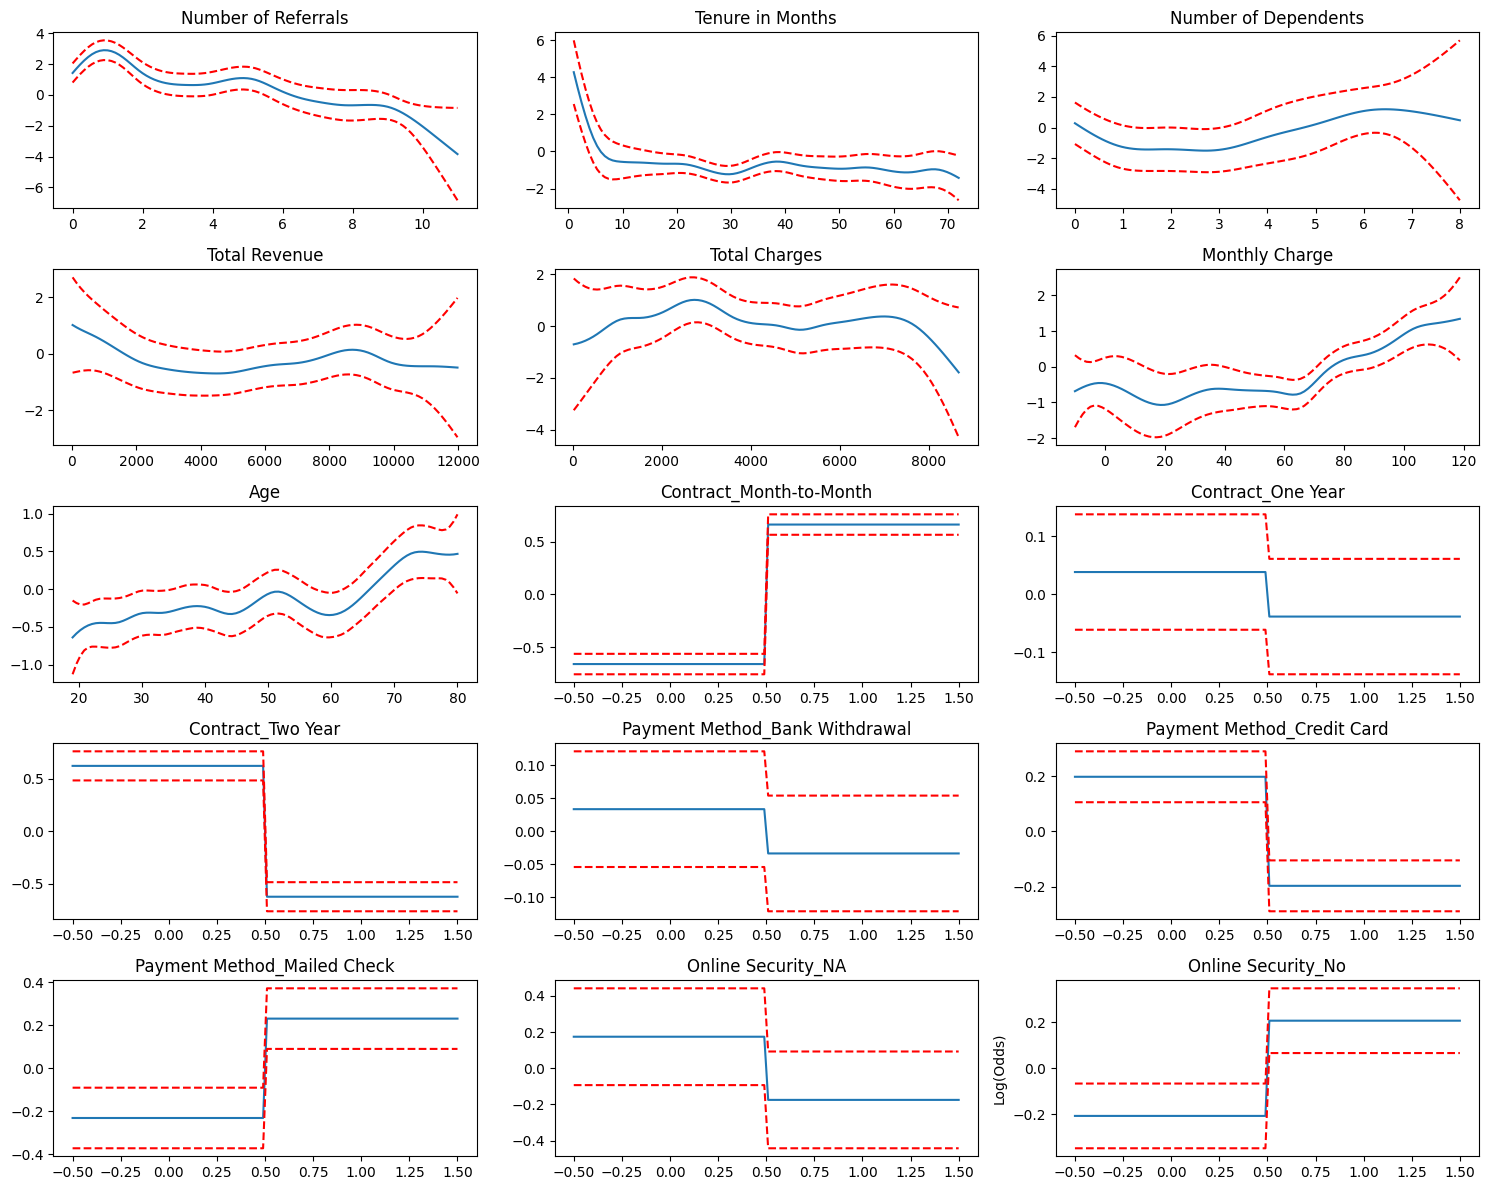

In [30]:
fig, axs = plt.subplots(5, 3, figsize=(15, 12))
titles = df_X_train_imp_subset_dummies.columns

for i, ax in enumerate(axs.ravel()):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

plt.ylabel("Log(Odds)")
plt.tight_layout()

## 3. L0Learn

### Training

In [ ]:
df_X_train_imp_dummies_floats = pd.get_dummies(df_X_train_imp, dtype='float')

user_lambda_grid = [[10, 4, 2, 1]]

cv_fit_result = l0learn.cvfit(df_X_train_imp_dummies_floats.values, 
                              y_train_numeric.values, 
                              num_folds=5, 
                              seed=42, 
                              penalty="L0", 
                              loss='Logistic',
                              num_gamma=None, 
                              num_lambda=None,
                              max_support_size=30, 
                              lambda_grid=user_lambda_grid)

cv_fit_result.characteristics().join(pd.Series(cv_fit_result.cv_means[0].flatten(), name='Loss'))

,l0,support_size,intercept,converged,l2,Loss
0,10.0,13,-1.120880,True,1.000000e-07,0.346144
1,4.0,14,-1.735673,True,1.000000e-07,0.346496
2,2.0,17,-1.669335,True,1.000000e-07,0.340327
3,1.0,27,-1.513366,True,1.000000e-07,0.341448


In [ ]:
# use the value of l0 that gives lowest loss
best_fit = l0learn.fit(df_X_train_imp_dummies_floats.values, 
                       y_train_numeric.values, 
                       penalty="L0", 
                       loss='Logistic', 
                       max_support_size=30, 
                       num_lambda=2)

### Evaluation and Visualization

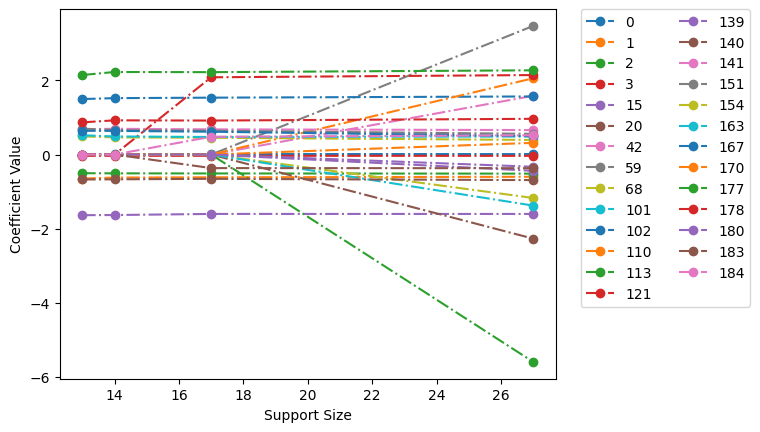

In [ ]:
cv_fit_result.plot(show_lines=True);

In [ ]:
df_X_test_imp_dummies_float = pd.get_dummies(df_X_test_imp, dtype='float')
l0learn_preds = cv_fit_result.predict(df_X_test_imp_dummies_float.values)[:, 2]
l0learn_preds = ['Churned' if x >= 0.5 else 'Stayed' for x in l0learn_preds]

In [ ]:
print(confusion_matrix(df_y_test, l0learn_preds))
f1_score(df_y_test.values, l0learn_preds, pos_label='Churned')

[[ 407  154]
 [ 136 1280]]


0.7373188405797102

In [ ]:
coefficients_l0learn = pd.DataFrame(zip(df_X_train_imp_dummies_floats.columns, 
                                        cv_fit_result.coeffs[0].toarray()[:, 2]),
                                        columns=['Column Name', 'Coefficient'])\
                                            .query('Coefficient != 0')

coefficients_l0learn['Coeff_abs'] = coefficients_l0learn['Coefficient'].abs()
coefficients_l0learn.sort_values(by='Coeff_abs', inplace=True, ascending=False)
coefficients_l0learn = coefficients_l0learn.drop(columns=['Coeff_abs'])

In [ ]:
coefficients_l0learn

,Column Name,Coefficient
177,Contract_Month-to-Month,2.223522
121,City_Temecula,2.084927
15,Married_No,-1.602811
102,City_San Diego,1.534998
178,Contract_One Year,0.917071
141,Offer_Offer E,0.679680
140,Offer_Offer D,-0.655289
151,Internet Type_Fiber Optic,0.643324
167,Streaming TV_Yes,0.615672
1,Number of Dependents,-0.615000


### Functional Relationship between Lambda and F1 Score

In [ ]:
user_lambda_grid_large = [[20, 15, 12, 10, 8, 6, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.75, 0.5, 0.1, 0.075, 0.05, 0.01, 0.001, 0.0001]]

cv_fit_result_grid = l0learn.cvfit(df_X_train_imp_dummies_floats.values, 
                                   y_train_numeric.values, 
                                   num_folds=5, 
                                   seed=42, 
                                   penalty="L0", 
                                   loss='Logistic',
                                   num_gamma=None, 
                                   num_lambda=None,
                                   max_support_size=30, 
                                   lambda_grid=user_lambda_grid_large)

grid_results = cv_fit_result_grid.characteristics()\
    .join(pd.Series(cv_fit_result_grid.cv_means[0].flatten(), name='Loss'))

In [ ]:
l0learn_preds_grid = cv_fit_result_grid.predict(df_X_test_imp_dummies_float.values)

def fx(x):
    return "Churned" if x >= 0.5 else "Stayed"

fx_vec = np.vectorize(fx)
l0learn_preds_grid = fx_vec(l0learn_preds_grid)

f1_score_list = []
for i in range(l0learn_preds_grid.shape[1]):
    f1_score_list.append(f1_score(df_y_test.values, 
                                  l0learn_preds_grid[:, i],
                                  pos_label='Churned'))

grid_results_df = grid_results.join(pd.Series(f1_score_list, name='F1 Score'))
grid_results_df.rename(columns={'support_size': 'Support Size'}, inplace=True)
grid_results_df

,l0,Support Size,intercept,converged,l2,Loss,F1 Score
0,20.00,7,-1.985782,True,1.000000e-07,0.388936,0.711071
1,15.00,8,-2.148039,True,1.000000e-07,0.381529,0.713775
2,12.00,9,-1.957586,True,1.000000e-07,0.361756,0.721371
3,10.00,9,-1.957509,True,1.000000e-07,0.356011,0.721371
4,8.00,11,-2.305416,True,1.000000e-07,0.351954,0.729412
5,6.00,11,-2.306790,True,1.000000e-07,0.350908,0.729412
6,5.00,12,-2.164697,True,1.000000e-07,0.349091,0.730734
7,4.50,12,-2.163485,True,1.000000e-07,0.349096,0.730734
8,4.00,12,-2.162429,True,1.000000e-07,0.349209,0.730734
9,3.50,14,-2.717137,True,1.000000e-07,0.346740,0.736174


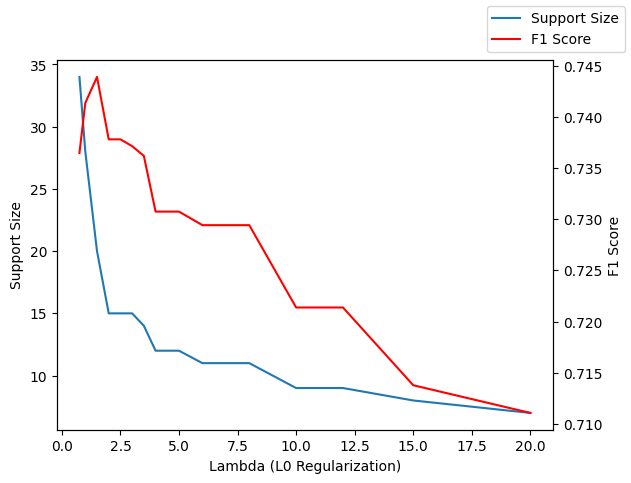

In [ ]:
ax = grid_results_df.plot(x="l0", y="Support Size", legend=False, ylabel='Support Size', xlabel='Lambda (L0 Regularization)')
ax2 = ax.twinx()
grid_results_df.plot(x="l0", y="F1 Score", ax=ax2, legend=False, color="r", ylabel='F1 Score')
ax.figure.legend()

plt.show();

## 4. EBM

In [ ]:
ebm_params = {
    'min_samples_leaf': [1, 2, 3, 4],
    'max_leaves': [2, 3, 4],
    'learning_rate': [0.01, 0.1]
}

cv = KFoldCrossValidator(ExplainableBoostingClassifier, 
                         param_dict=ebm_params, 
                         metric='F1 Score', 
                         folds=4)

cv_results = cv.run_validation(df_X_train_imp.join(pd.Series(y_train_numeric, name='Target')))



Fold: 1
{'min_samples_leaf': 1, 'max_leaves': 2, 'learning_rate': 0.01, 'F1 Score': 0.814935064935065}
{'min_samples_leaf': 1, 'max_leaves': 2, 'learning_rate': 0.1, 'F1 Score': 0.8122977346278318}
{'min_samples_leaf': 1, 'max_leaves': 2, 'learning_rate': 0.001, 'F1 Score': 0.8058252427184466}
{'min_samples_leaf': 1, 'max_leaves': 3, 'learning_rate': 0.01, 'F1 Score': 0.821256038647343}
{'min_samples_leaf': 1, 'max_leaves': 3, 'learning_rate': 0.1, 'F1 Score': 0.8187702265372169}
{'min_samples_leaf': 1, 'max_leaves': 3, 'learning_rate': 0.001, 'F1 Score': 0.8244766505636071}
{'min_samples_leaf': 1, 'max_leaves': 4, 'learning_rate': 0.01, 'F1 Score': 0.821256038647343}
{'min_samples_leaf': 1, 'max_leaves': 4, 'learning_rate': 0.1, 'F1 Score': 0.8186195826645265}
{'min_samples_leaf': 1, 'max_leaves': 4, 'learning_rate': 0.001, 'F1 Score': 0.8224000000000001}
{'min_samples_leaf': 1, 'max_leaves': 5, 'learning_rate': 0.01, 'F1 Score': 0.8282504012841092}
{'min_samples_leaf': 1, 'max_leav

### Training

In [43]:
best_ebm_params = cv_results['best_overall']
# del best_ebm_params['F1 Score']

ebm = ExplainableBoostingClassifier(**best_ebm_params)
ebm.fit(df_X_train_imp, y_train_numeric)

ExplainableBoostingClassifier(max_leaves=5, min_samples_leaf=4)

In [11]:
with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(df_X_train_imp, df_y_train)
   show(ebm_local)

/home/vscode/.venv/lib/python3.10/site-packages/interpret/visual/_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/vscode/.venv/lib/python3.10/site-packages/interpret/visual/_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/140249444700352/ -->

/home/vscode/.venv/lib/python3.10/site-packages/interpret/visual/_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/140249444701936/ -->

In [44]:
preds_ebm = ebm.predict(df_X_test_imp).astype('float')

print(confusion_matrix(y_test_numeric, preds_ebm))
f1_score(y_test_numeric, preds_ebm, pos_label=1)

[[1337   79]
 [ 163  398]]


0.766859344894027

# Variable Importance
***

In [19]:
tuned_parameters = [{'criterion':['gini', 'entropy'],
                     'max_leaf_nodes': range(5,25)}] # hyperparameters to tune

clf_D = GridSearchCV(DecisionTreeClassifier(), 
                     tuned_parameters, 
                     verbose=1, 
                     n_jobs=-1) # grid search model

with warnings.catch_warnings():
   warnings.simplefilter("ignore")
   clf_D.fit(df_X_train_imp_dummies, df_y_train) # evaluate hyper-parameters

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/vscode/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/vscode/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/vscode/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/vscode/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

In [21]:
perm = PermutationImportance(clf_D.best_estimator_, 
                             random_state=1).fit(df_X_test_imp_dummies, df_y_test)
weights = eli5.show_weights(perm, feature_names = df_X_test_imp_dummies.columns.tolist())


In [25]:
weights

Weight,Feature
0.1172 ± 0.0052,Contract_Month-to-Month
0.0735 ± 0.0087,Tenure in Months
0.0313 ± 0.0060,Age
0.0309 ± 0.0082,Number of Referrals
0.0185 ± 0.0038,Monthly Charge
0.0094 ± 0.0039,Number of Dependents
0.0060 ± 0.0033,Total Charges
0.0035 ± 0.0033,City_San Diego
0 ± 0.0000,City_Mission Viejo
0 ± 0.0000,City_Merced
